In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.manifold import TSNE

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# Load MNIST dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)



batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [10]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation at the output layer
        return x

In [11]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

fc1.weight torch.Size([30, 784])
fc1.bias torch.Size([30])
fc2.weight torch.Size([20, 30])
fc2.bias torch.Size([20])
fc3.weight torch.Size([10, 20])
fc3.bias torch.Size([10])


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1)%5 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 5/20, Loss: 0.0706
Epoch 10/20, Loss: 0.1287
Epoch 15/20, Loss: 0.0720
Epoch 20/20, Loss: 0.0061


Test Accuracy: 0.9651

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.96      0.96      0.96       892
           6       0.98      0.97      0.98       958
           7       0.93      0.98      0.95      1028
           8       0.96      0.93      0.95       974
           9       0.99      0.93      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000



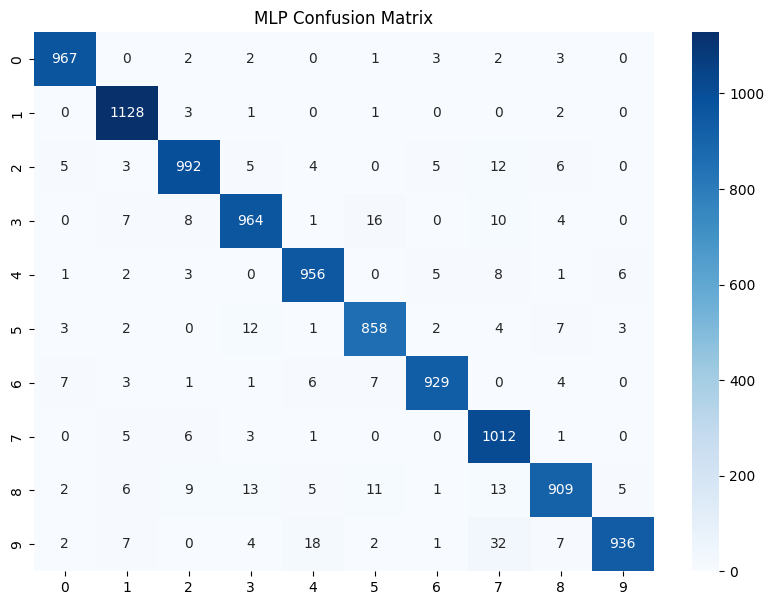

In [13]:
# Evaluate on test data
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())



# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Optionally, print classification report and confusion matrix for more details
print("\nClassification Report:\n", classification_report(y_true, y_pred))


# Confusion Matrix for MLP
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.show()

MLP F1 Score: 0.965055335109268
RF F1 Score: 0.9703722598097007
Logistic Regression F1 Score: 0.9254454253831236


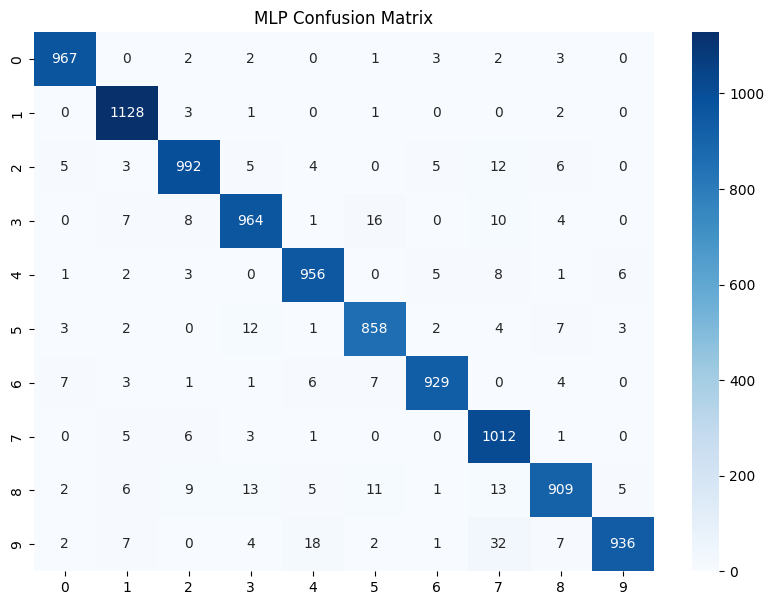

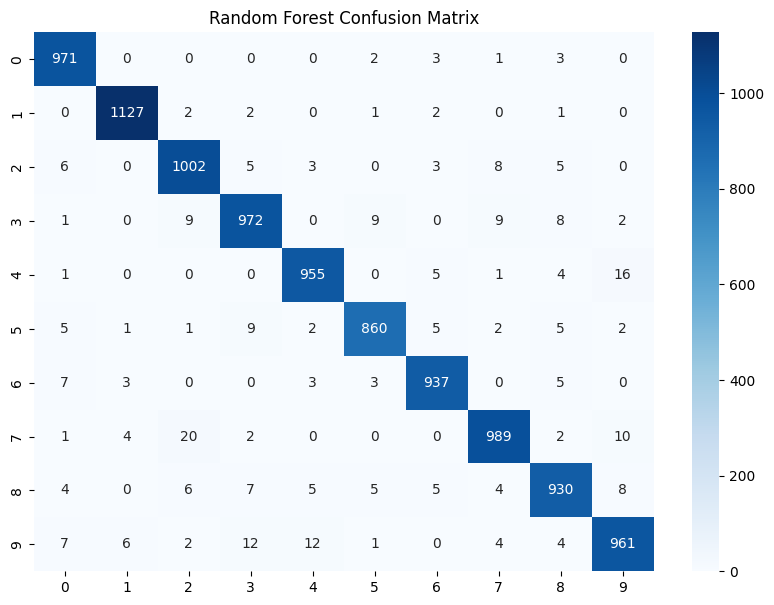

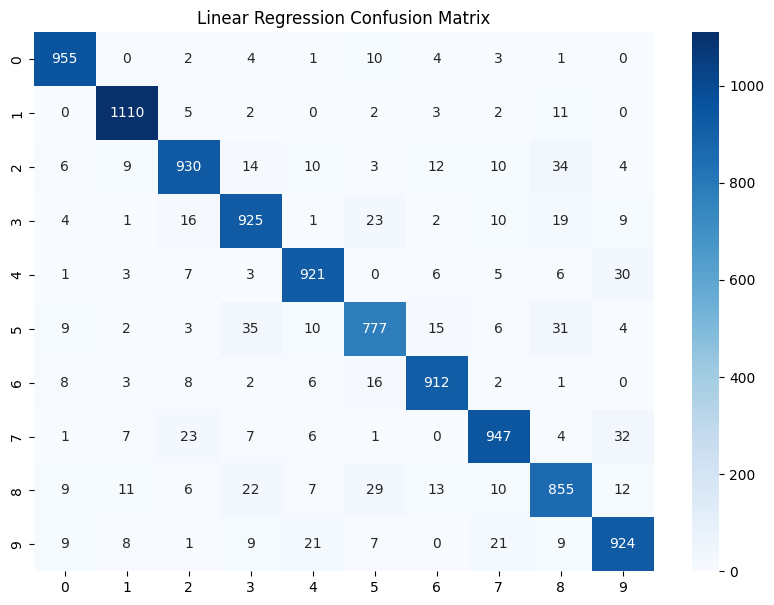

In [14]:
# Flatten data for scikit-learn models
X_train = train_data.data.numpy().reshape(len(train_data), -1) / 255.0  # normalize pixel values
X_test = test_data.data.numpy().reshape(len(test_data), -1) / 255.0
y_train = train_data.targets.numpy()
y_test = test_data.targets.numpy()

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Train on a subset if needed
y_pred_rf = rf.predict(X_test)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Print F1-scores and confusion matrix
print("MLP F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print("RF F1 Score:", f1_score(y_test, y_pred_rf, average="weighted"))
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_lr, average="weighted"))

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.show()
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Linear Regression Confusion Matrix")
plt.show()

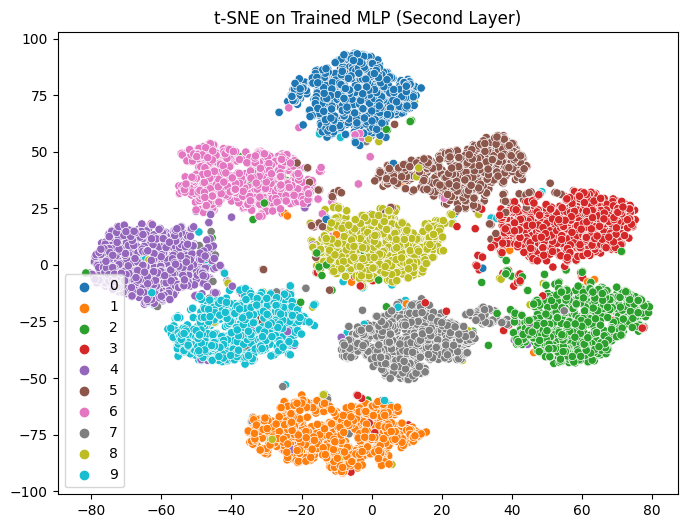

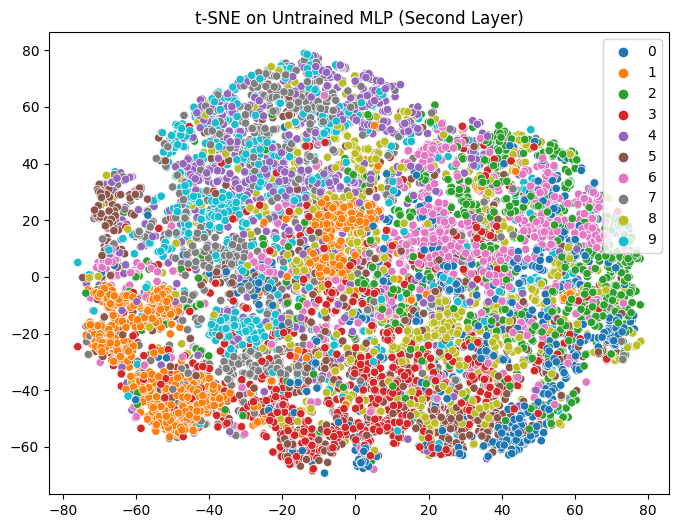

In [15]:
# Function to get layer outputs
def get_layer_outputs(model, data_loader):
    model.eval()
    layer_outputs, labels = [], []
    with torch.no_grad():
        for images, lbls in data_loader:
            images, lbls = images.to(device), lbls.to(device)  
            x = images.view(-1, 28*28)
            x = torch.relu(model.fc1(x))  # Pass through first layer
            x = torch.relu(model.fc2(x))  # Get second layer outputs
            layer_outputs.append(x)
            labels.extend(lbls.cpu().numpy())  
    return torch.cat(layer_outputs).cpu().numpy(), labels

# Get t-SNE embeddings for trained model
layer_outputs_trained, labels = get_layer_outputs(model, test_loader)
tsne_trained = TSNE(n_components=2).fit_transform(layer_outputs_trained)

# Plot t-SNE for trained model
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_trained[:, 0], y=tsne_trained[:, 1], hue=labels, palette="tab10", legend="full")
plt.title("t-SNE on Trained MLP (Second Layer)")
plt.show()

# Repeat for untrained model
untrained_model = MLP().to(device)  # Untrained model
layer_outputs_untrained, _ = get_layer_outputs(untrained_model, test_loader)
tsne_untrained = TSNE(n_components=2).fit_transform(layer_outputs_untrained)

# Plot t-SNE for untrained model
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_untrained[:, 0], y=tsne_untrained[:, 1], hue=labels, palette="tab10", legend="full")
plt.title("t-SNE on Untrained MLP (Second Layer)")
plt.show()

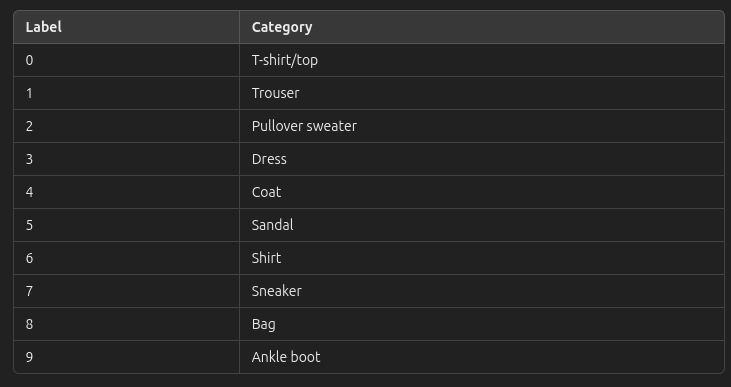

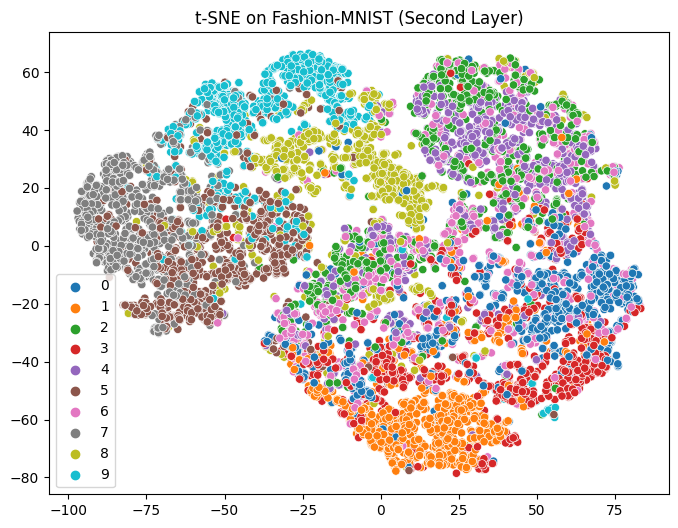

In [17]:
# Load Fashion-MNIST
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_loader = torch.utils.data.DataLoader(fashion_test, batch_size=64, shuffle=False)

# Get layer outputs for Fashion-MNIST
fashion_layer_outputs, fashion_labels = get_layer_outputs(model, fashion_loader)
tsne_fashion = TSNE(n_components=2).fit_transform(fashion_layer_outputs)

# Plot t-SNE for Fashion-MNIST
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_fashion[:, 0], y=tsne_fashion[:, 1], hue=fashion_labels, palette="tab10", legend="full")
plt.title("t-SNE on Fashion-MNIST (Second Layer)")
plt.show()


Test Accuracy on MNIST: 0.0613

F1 Score: 0.0625



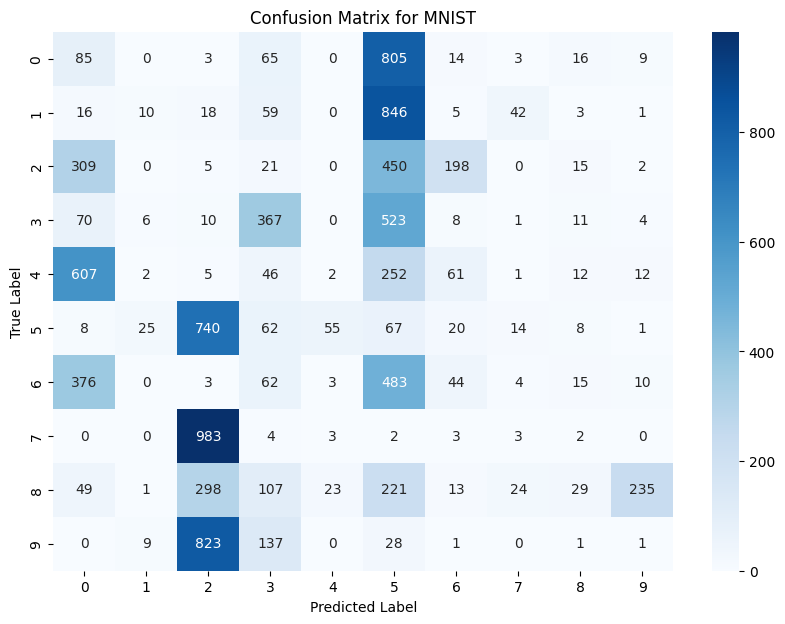

In [21]:
model.eval()

# Evaluate on test data
y_true_fashion, y_pred_fashion = [], []
with torch.no_grad():
    for images, labels in fashion_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        output = model(images)
        _, predicted = torch.max(output, 1)
        y_true_fashion.extend(labels.cpu().numpy())
        y_pred_fashion.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true_fashion, y_pred_fashion)
print(f"Test Accuracy on MNIST: {accuracy:.4f}\n")
# Optional: Calculate F1-Score
f1 = f1_score(y_true_fashion, y_pred_fashion, average="weighted")
print(f"F1 Score: {f1:.4f}\n")

# Confusion Matrix for MNIST
plt.figure(figsize=(10, 7))
conf_matrix = confusion_matrix(y_true_fashion, y_pred_fashion)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for MNIST")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




The digits that are commonly confused are (4,9), (3, 5), (8, 5)